In [6]:
using BSON: @save
using BSON: @load
using CSV
using DataFrames: DataFrame
using Flux
using Flux: logitbinarycrossentropy, binarycrossentropy
using Flux.Data: DataLoader
using Flux: chunk
using ImageFiltering
using MLDatasets: FashionMNIST
using ProgressMeter: Progress, next!
using Random
using Zygote
using MLDatasets
using Images
using ImageIO
using LinearAlgebra
using FFTW

In [2]:
# We define a reshape layer to use in our decoder
struct Reshape
    shape
end
Reshape(args...) = Reshape(args)
(r::Reshape)(x) = reshape(x, r.shape)
Flux.@functor Reshape ()

In [3]:
function get_train_loader(batch_size, shuffle::Bool)
    # The MNIST training set is made up of 60k 28 by 28 greyscale images
    train_x, train_y = MNIST.traindata(Float32)
    train_x = 1 .- reshape(train_x, (784, :))
    return DataLoader((train_x, train_y), batchsize=batch_size, shuffle=shuffle, partial=false)
end

function save_model(encoder_μ, encoder_logvar, decoder, decoder_last, save_dir::String, epoch::Int)
    print("Saving model...")
    let encoder_μ = cpu(encoder_μ), encoder_logvar = cpu(encoder_logvar), decoder = cpu(decoder), decoder_last = cpu(decoder_last)
        @save joinpath(save_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder decoder_last
    end
    println("Done")
end

function create_vae()
    # Define the encoder and decoder networks
    encoder_features = Chain(
        Dense(784,500, relu),
        Dense(500,500, relu)
    )
    encoder_μ = Chain(encoder_features, Dense(500, 20))
    encoder_logvar = Chain(encoder_features, Dense(500, 20))

    decoder = Chain(
        Dense(20, 500, relu, bias = false),
        Dense(500, 500, relu, bias = false),
    )

    decoder_last = randn(784,500)

    return encoder_μ, encoder_logvar, decoder, decoder_last
end

create_vae (generic function with 1 method)

In [32]:
function vae_loss(encoder_μ, encoder_logvar, decoder, decoder_last, x, β, λ, F)
    batch_size = size(x)[end]
    @assert batch_size != 0

    # Forward propagate through mean encoder and std encoders
    μ = encoder_μ(x)
    logvar = encoder_logvar(x)
    # Apply reparameterisation trick to sample latent
    z = μ + randn(Float32, size(logvar)) .* exp.(0.5f0 * logvar)
    # Reconstruct from latent sample
    x̂ = decoder_last * decoder(z)

    loss_α(F,A) = maximum(sqrt.(sum((F*A).*(F*A), dims = 2))) + norm(A'*A - I(500),2)^2
    α = loss_α(F,decoder_last)
    
    # Negative reconstruction loss Ε_q[logp_x_z]
    logp_x_z = -sum(logitbinarycrossentropy.(x̂, x)) 
    # KL(qᵩ(z|x)||p(z)) where p(z)=N(0,1) and qᵩ(z|x) models the encoder i.e. reverse KL
    # The @. macro makes sure that all operates are elementwise
    kl_q_p = 0.5f0 * sum(@. (exp(logvar) + μ^2 - logvar - 1f0)) 
    # Weight decay regularisation term
    reg = λ * sum(x->sum(x.^2), Flux.params(encoder_μ, encoder_logvar, decoder, decoder_last))
    # We want to maximise the evidence lower bound (ELBO)
    elbo = logp_x_z - β .* kl_q_p
    # So we minimise the sum of the negative ELBO and a weight penalty
    return -elbo + Flux.mse(x̂, x) + reg + α
end

function train(encoder_μ, encoder_logvar, decoder, decoder_last, dataloader, num_epochs, λ, β, optimiser, save_dir)
    # The training loop for the model
    trainable_params = Flux.params(encoder_μ, encoder_logvar, decoder, decoder_last)
    progress_tracker = Progress(num_epochs, "Training a epoch done")
    F = dct(diagm(ones(784)),2);

    for epoch_num = 1:num_epochs
        acc_loss = 0.0
        loss = 0
        for (x_batch, y_batch) in dataloader
            # pullback function returns the result (loss) and a pullback operator (back)
            loss, back = pullback(trainable_params) do
                vae_loss(encoder_μ, encoder_logvar, decoder, decoder_last, x_batch, β, λ, F)
            end
            # Feed the pullback 1 to obtain the gradients and update then model parameters
            gradients = back(1f0)
            Flux.Optimise.update!(optimiser, trainable_params, gradients)
            if isnan(loss)
                break
            end
            acc_loss += loss
        end
        next!(progress_tracker; showvalues=[(:loss, loss)])
        println()
        @assert length(dataloader) > 0
        avg_loss = acc_loss / length(dataloader)
        metrics = DataFrame(epoch=epoch_num, negative_elbo=avg_loss)
        # println(metrics)
        CSV.write(joinpath(save_dir, "metrics.csv"), metrics, header=(epoch_num==1), append=true)
        save_model(encoder_μ, encoder_logvar, decoder, decoder_last, save_dir, epoch_num)
    end
    println("Training complete!")
end

train (generic function with 1 method)

In [41]:
batch_size = 64
shuffle_data = true
η = 0.001
β = 1f0
λ = 0.01f0
num_epochs = 20
save_dir = "trained_GNN/MNIST_identity"
# Define the model and create our data loader
dataloader = get_train_loader(batch_size, shuffle_data)
encoder_μ, encoder_logvar, decoder, decoder_last = create_vae()
train(encoder_μ, encoder_logvar, decoder, decoder_last, dataloader, num_epochs, λ, β, ADAM(η), save_dir)

┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:187



Saving model...

Done


Training a epoch done  10%|███                           |  ETA: 0:52:17


Saving model...Done



Training a epoch done  15%|████▌                         |  ETA: 0:50:39



Saving model...Done



Training a epoch done  20%|██████                        |  ETA: 0:48:19



Saving model...

Done



Training a epoch done  25%|███████▌                      |  ETA: 0:45:37



Saving model...

Done



Training a epoch done  30%|█████████                     |  ETA: 0:42:40



Saving model...Done



Training a epoch done  35%|██████████▌                   |  ETA: 0:39:31



Saving model...Done



Training a epoch done  40%|████████████                  |  ETA: 0:36:23



Saving model...Done



Training a epoch done  45%|█████████████▌                |  ETA: 0:33:19



Saving model...Done



Training a epoch done  50%|███████████████               |  ETA: 0:30:18



Saving model...Done



Training a epoch done  55%|████████████████▌             |  ETA: 0:27:15



Saving model...Done



Training a epoch done  60%|██████████████████            |  ETA: 0:24:13



Saving model...Done



Training a epoch done  65%|███████████████████▌          |  ETA: 0:21:07



Saving model...

Done



Training a epoch done  70%|█████████████████████         |  ETA: 0:18:03


In [34]:
function get_test_loader(batch_size, shuffle::Bool)
    # The FashionMNIST test set is made up of 10k 28 by 28 greyscale images
    test_x, test_y = MNIST.testdata(Float32)
    test_x = 1 .- reshape(test_x, (784, :))
    return DataLoader((test_x, test_y), batchsize=batch_size, shuffle=shuffle)
end

function save_to_images(x_batch, save_dir::String, prefix::String, num_images::Int64)
    @assert num_images <= size(x_batch)[2]
    for i=1:num_images
        save(joinpath(save_dir, "$prefix-$i.png"), colorview(Gray, reshape(x_batch[:, i], 28,28)' ))
    end
end

function reconstruct_images(encoder_μ, encoder_logvar, decoder, x)
    # Forward propagate through mean encoder and std encoders
    μ = encoder_μ(x)
    logvar = encoder_logvar(x)
    # Apply reparameterisation trick to sample latent
    z = μ + randn(Float32, size(logvar)) .* exp.(0.5f0 * logvar)
    # Reconstruct from latent sample
    x̂ = decoder(z)
    return clamp.(x̂, 0 ,1)
end

function load_model(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder
    println("Done")
    return encoder_μ, encoder_logvar, decoder
end

function visualise()
    # Define some parameters
    batch_size = 64
    shuffle = true
    num_images = 30
    epoch_to_load = 9
    # Load the model and test set loader
    dir = "trained_GNN/MNIST_identity"
    encoder_μ, encoder_logvar, decoder = load_model(dir, epoch_to_load)
    dataloader = get_test_loader(batch_size, shuffle)
    # Reconstruct and save some images
    for (x_batch, y_batch) in dataloader
        save_to_images(x_batch, dir, "test-image", num_images)
        x̂_batch = reconstruct_images(encoder_μ, encoder_logvar, decoder, x_batch)
        save_to_images(x̂_batch, dir, "reconstruction", num_images)
        break
    end
end


visualise (generic function with 1 method)

In [34]:
visualise()

Loading model...Done


┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:195


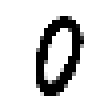

In [266]:
load("trained_GNN/MNIST_identity/reconstruction-3.png")

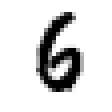

In [100]:
load("result/test-image-3.png")

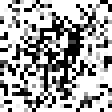

In [37]:
colorview(Gray, reshape(decoder_last * decoder(randn(20)), 28,28)' )

In [36]:
using NBInclude
@nbinclude("functions.ipynb")


All function imported


In [40]:
subspace_incoherence(dct(diagm(ones(784)),2), decoder_last)

0.8527404850825198

In [136]:
x_dim = 4000
k = 100
F = dct(diagm(ones(x_dim)),2);

α = []
Threads.@threads for trial in 1:10
    A = sample_fourier(k,x_dim); A = A'
    for i in 1:100
        θ = Flux.params(A)
        gs = gradient(()->subspace_incoherence_2(F,A), θ )
        A .-= .1 * (gs[A] + randn(x_dim,k) * (.5)^i)
    end
    push!(α,subspace_incoherence(F,A))
end



TaskFailedException: TaskFailedException

    nested task error: InterruptException:
    Stacktrace:
      [1] Array
        @ ./boot.jl:459 [inlined]
      [2] Array
        @ ./boot.jl:467 [inlined]
      [3] similar
        @ ./array.jl:378 [inlined]
      [4] *
        @ /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/stdlib/v1.7/LinearAlgebra/src/matmul.jl:153 [inlined]
      [5] #1393
        @ ~/.julia/packages/ChainRules/CBSzG/src/rulesets/Base/arraymath.jl:37 [inlined]
      [6] unthunk
        @ ~/.julia/packages/ChainRulesCore/16PWJ/src/tangent_types/thunks.jl:195 [inlined]
      [7] wrap_chainrules_output
        @ ~/.julia/packages/Zygote/IoW2g/src/compiler/chainrules.jl:104 [inlined]
      [8] map
        @ ./tuple.jl:223 [inlined]
      [9] wrap_chainrules_output
        @ ~/.julia/packages/Zygote/IoW2g/src/compiler/chainrules.jl:105 [inlined]
     [10] ZBack
        @ ~/.julia/packages/Zygote/IoW2g/src/compiler/chainrules.jl:205 [inlined]
     [11] Pullback
        @ ~/Documents/GitHub/GNN_Isometries/train_vae_relu_sig.ipynb:3 [inlined]
     [12] (::typeof(∂(subspace_incoherence_2)))(Δ::Float64)
        @ Zygote ~/.julia/packages/Zygote/IoW2g/src/compiler/interface2.jl:0
     [13] Pullback
        @ ~/Documents/GitHub/GNN_Isometries/train_vae_relu_sig.ipynb:10 [inlined]
     [14] (::typeof(∂(λ)))(Δ::Float64)
        @ Zygote ~/.julia/packages/Zygote/IoW2g/src/compiler/interface2.jl:0
     [15] (::Zygote.var"#97#98"{Params{Zygote.Buffer{Any, Vector{Any}}}, typeof(∂(λ)), Zygote.Context})(Δ::Float64)
        @ Zygote ~/.julia/packages/Zygote/IoW2g/src/compiler/interface.jl:357
     [16] gradient(f::Function, args::Params{Zygote.Buffer{Any, Vector{Any}}})
        @ Zygote ~/.julia/packages/Zygote/IoW2g/src/compiler/interface.jl:76
     [17] macro expansion
        @ ~/Documents/GitHub/GNN_Isometries/train_vae_relu_sig.ipynb:10 [inlined]
     [18] (::var"#433#threadsfor_fun#201"{UnitRange{Int64}})(onethread::Bool)
        @ Main ./threadingconstructs.jl:85
     [19] (::var"#433#threadsfor_fun#201"{UnitRange{Int64}})()
        @ Main ./threadingconstructs.jl:52

In [138]:
α

Any[]

In [33]:
function subspace_incoherence_2(F,A)
    m,n = size(A)
    maximum(sqrt.(sum((A'*F').*(A'*F'), dims = 1))) + norm(A'*A - I(n),2)^2
end


subspace_incoherence_2 (generic function with 1 method)

In [ ]:
x_dim = 400
k = 10
F = dct(diagm(ones(x_dim)),2);
A = sample_fourier(k,x_dim); A = A'
print(A[1,1])
loss(F,A) = maximum(sqrt.(sum((A'*F').*(A'*F'), dims = 1))) + norm(A'*A - I(k),2)^2

θ = Flux.params(A)
# gs = gradient(()->loss(F), θ)
# Flux.Optimise.update!(opt, A, gs[A]);

opt = Descent(.1)
for i in 1:100
    gs = gradient(()->loss(F,A), A)
    Flux.Optimise.update!(opt, A, gs[A]);
    # A = A + randn(400,10)*.5^i
    # θ = Flux.params(A)

end

gs[A]


400×10 Matrix{Float64}:
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
   ⋮                        ⋮                 
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN

In [261]:
subspace_incoherence(F,A)

NaN

In [254]:
A



400×10 adjoint(::Matrix{Float64}) with eltype Float64:
  0.05         0.05         0.05       …   0.0497751    0.05
  0.0690678    0.0615586    0.0628771     -0.0661369    0.0221147
  0.0642154    0.0364715    0.0411121      0.0538843   -0.0568779
  0.0563791    0.00194351   0.0102381     -0.0351165   -0.0576918
  0.0459229   -0.0330876   -0.0229044      0.0121025    0.0207918
  0.0333328   -0.0595537   -0.050972   …   0.0123748    0.070697
  0.0191937   -0.0706038   -0.067746      -0.0353558    0.0234291
  0.00416279  -0.0633774   -0.0695097      0.0540618   -0.0560422
 -0.0110616   -0.0397453   -0.0558724     -0.066231    -0.0584834
 -0.025772    -0.00582467  -0.0298557      0.070392     0.0194608
  ⋮                                    ⋱               
 -0.0658468    0.0704703   -0.0640987      0.00027643   0.06798
 -0.0698401    0.0584834   -0.0433391      0.0238446    0.0397453
 -0.070588     0.0313575   -0.012977      -0.0450826   -0.0431193
 -0.0680559   -0.00388556   0.0202603  